# Face pose-based image retrieval

In [208]:
import numpy as np

# Load test set prediction results
data1 = np.loadtxt("results.csv",delimiter = ",")
points = data1.reshape(data1.shape[0],32,2)

# Load test images
test = np.load('test_images.npz',allow_pickle=True)
# Extract the images
testImages1 = test['images']

In [2]:
import cv2
import numpy as np
from PIL import Image

# Simulate camera internal parameters
img_size=(242, 242)
focal_length = img_size[0]
camera_center = (img_size[1] / 2,img_size[0] / 2)
cam_matrix = np.array(
    [[focal_length, 0, camera_center[0]],
    [0, focal_length,camera_center[1]],
    [0, 0, 1]], dtype="double")

dist_coeffs = np.zeros((4, 1))

# Set the key point coordinates of the head 3D general model
object_pts_6 = np.array([
            (0.0, 0.0, 0.0),             # Nose tip 34
            (0.0, -330.0, -65.0),        # Chin  9
            (-225.0, 170.0, -135.0),     # Left eye left corner 46
            (225.0, 170.0, -135.0),      # Right eye right corne 37
            (-150.0, -150.0, -125.0),    # Left Mouth corner 55
            (150.0, -150.0, -125.0)      # Right mouth corner 49
        ], dtype=float) / 4.5



object_pts_14 = np.float32([[6.825897, 6.760612, 4.402142],
                         [1.330353, 7.122144, 6.903745],
                         [-1.330353, 7.122144, 6.903745],
                         [-6.825897, 6.760612, 4.402142],
                         [5.311432, 5.485328, 3.987654],
                         [1.789930, 5.393625, 4.413414],
                         [-1.789930, 5.393625, 4.413414],
                         [-5.311432, 5.485328, 3.987654],
                         [2.005628, 1.409845, 6.165652],
                         [-2.005628, 1.409845, 6.165652],
                         [2.774015, -2.080775, 5.048531],
                         [-2.774015, -2.080775, 5.048531],
                         [0.000000, -3.116408, 6.097667],
                         [0.000000, -7.415691, 4.070434]])

reprojectsrc = np.float32 ([[10.0, 10.0, 10.0],
                        [10.0, -10.0, 10.0],
                        [-10.0, 10.0, 10.0],
                        [-10.0, -10.0, 10.0]])

In [3]:
def get_head_pose(shape,point_number):
# Select the point coordinates needed for pose estimation
    if point_number==14:
        image_pts = np.float32([shape[9], shape[10], shape[11], shape[12], shape[18],
                            shape[19], shape[20], shape[21], shape[15], shape[17],
                            shape[29], shape[25], shape[27], shape[4]])
        
        _, rotation_vec, translation_vec = cv2.solvePnP(object_pts_14, image_pts, cam_matrix, dist_coeffs)
    elif point_number==6:
        image_pts = np.float32([shape[14], shape[4],
                            shape[21], shape[18], shape[25], shape[29]])
        
        _, rotation_vec, translation_vec = cv2.solvePnP(object_pts_6, image_pts, cam_matrix, dist_coeffs)

#     Get the projected 2D coordinates by the given 3D coordinates
    reprojectdst, _ = cv2.projectPoints(reprojectsrc, rotation_vec, translation_vec, cam_matrix,
                                        dist_coeffs)

    reprojectdst = tuple(map(tuple, reprojectdst.reshape(4, 2)))

    # calc euler angle
    rotation_mat, _ = cv2.Rodrigues(rotation_vec)
    pose_mat = cv2.hconcat((rotation_mat, translation_vec))
    _, _, _, _, _, _, euler_angle = cv2.decomposeProjectionMatrix(pose_mat)

    return reprojectdst, euler_angle

In [196]:
# Use euler_angle to store the pitch, yaw, roll of all test data
euler_angle = np.zeros((data1.shape[0], 3))
for i in range(data1.shape[0]):
    r, e=get_head_pose(points[i],6)
    euler_angle[i][0],euler_angle[i][1],euler_angle[i][2]=e[0][0],e[1][0],e[2][0]

In [197]:
def get_most_similar_image(user_euler,euler_angle):
    nums = np.zeros((data1.shape[0],1))
    for i in range(data1.shape[0]):
        num=(user_euler[0][0]-euler_angle[i][0])*(user_euler[0][0]-euler_angle[i][0])+(user_euler[1][0]-euler_angle[i][1])*(user_euler[1][0]-euler_angle[i][1])+(user_euler[2][0]-euler_angle[i][2])*(user_euler[2][0]-euler_angle[i][2])
        nums[i]=num
    return nums            

In [209]:
# Randomly select a picture
# Find the three images with the closest poses
index=np.zeros((5,4))
for i in range(5):
    idx = np.random.randint(0, data1.shape[0])
    r, e=get_head_pose(points[idx],6)
    nums=get_most_similar_image(e,euler_angle)
    nums=nums.reshape(-1)
    
    index[i][0]=idx
    index[i][1]=np.where(nums==nums[np.argpartition(nums, 1)[1]])[0][0]
    index[i][2]=np.where(nums==nums[np.argpartition(nums, 2)[2]])[0][0]
    index[i][3]=np.where(nums==nums[np.argpartition(nums, 3)[3]])[0][0]

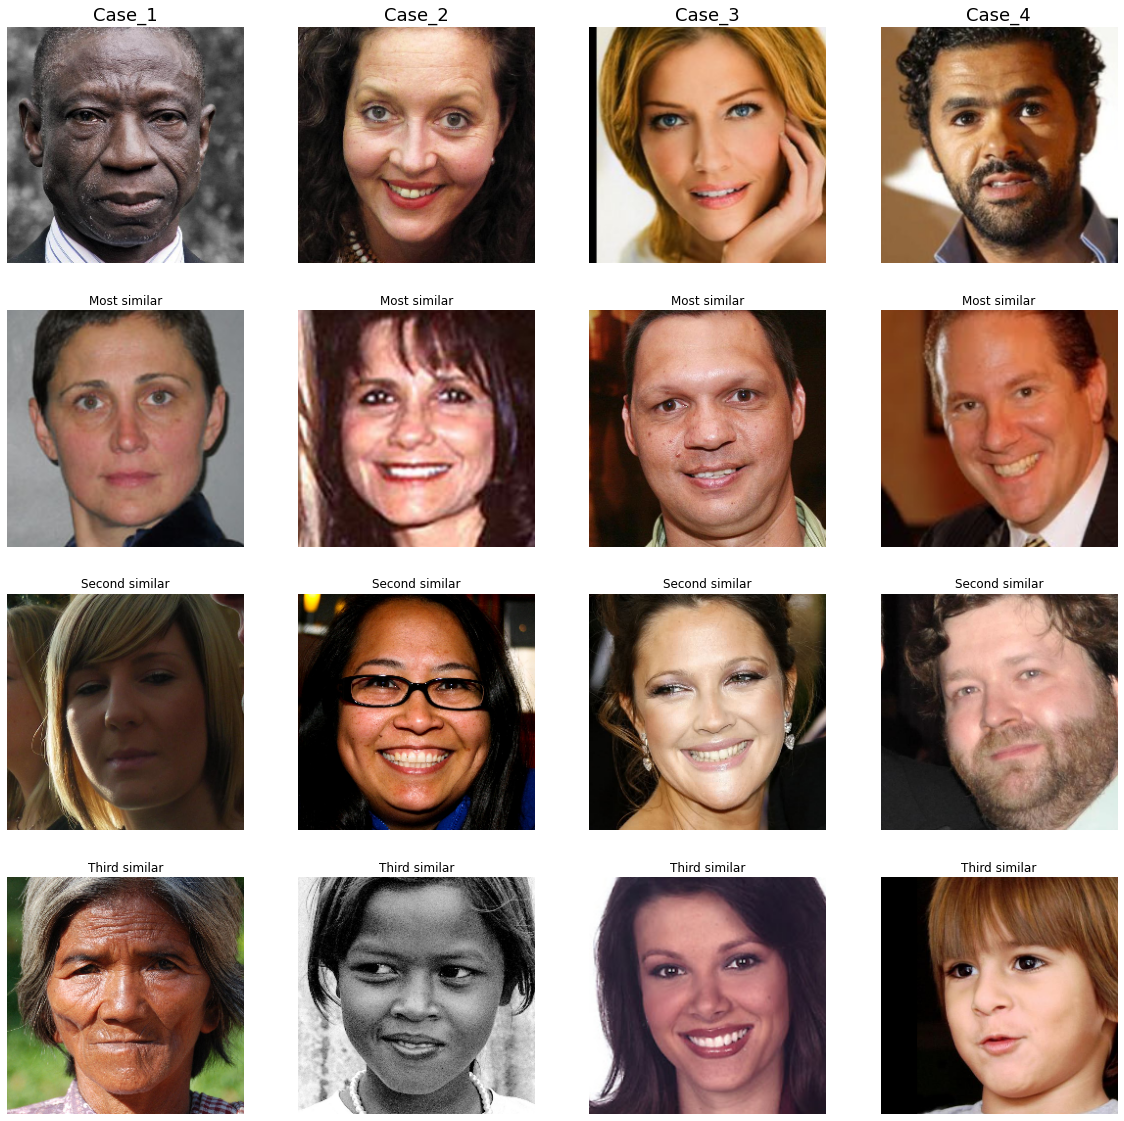

In [210]:
# Image visualization

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20)) #Set size

plt.subplot(4,4,1), plt.title('Case_1',fontsize=18)
plt.imshow(testImages1[int(index[0][0])]), plt.axis('off')
plt.subplot(4,4,2), plt.title('Case_2',fontsize=18)
plt.imshow(testImages1[int(index[1][0])]), plt.axis('off')
plt.subplot(4,4,3), plt.title('Case_3',fontsize=18)
plt.imshow(testImages1[int(index[2][0])]), plt.axis('off')
plt.subplot(4,4,4), plt.title('Case_4',fontsize=18)
plt.imshow(testImages1[int(index[3][0])]), plt.axis('off')

plt.subplot(4,4,5), plt.title('Most similar')
plt.imshow(testImages1[int(index[0][1])]), plt.axis('off')
plt.subplot(4,4,6), plt.title('Most similar')
plt.imshow(testImages1[int(index[1][1])]), plt.axis('off')
plt.subplot(4,4,7), plt.title('Most similar')
plt.imshow(testImages1[int(index[2][1])]), plt.axis('off')
plt.subplot(4,4,8), plt.title('Most similar')
plt.imshow(testImages1[int(index[3][1])]), plt.axis('off')

plt.subplot(4,4,9), plt.title('Second similar')
plt.imshow(testImages1[int(index[0][2])]), plt.axis('off')
plt.subplot(4,4,10), plt.title('Second similar')
plt.imshow(testImages1[int(index[1][2])]), plt.axis('off')
plt.subplot(4,4,11), plt.title('Second similar')
plt.imshow(testImages1[int(index[2][2])]), plt.axis('off')
plt.subplot(4,4,12), plt.title('Second similar')
plt.imshow(testImages1[int(index[3][2])]), plt.axis('off')

plt.subplot(4,4,13), plt.title('Third similar')
plt.imshow(testImages1[int(index[0][3])]), plt.axis('off')
plt.subplot(4,4,14), plt.title('Third similar')
plt.imshow(testImages1[int(index[1][3])]), plt.axis('off')
plt.subplot(4,4,15), plt.title('Third similar')
plt.imshow(testImages1[int(index[2][3])]), plt.axis('off')
plt.subplot(4,4,16), plt.title('Third similar')
plt.imshow(testImages1[int(index[3][3])]), plt.axis('off')

plt.show()
